<a href="https://colab.research.google.com/github/jpsiegel/Projects/blob/master/Tarea1_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Tarea 1 Jan P. Siegel - Deep Learning


In [1]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU

In [73]:
GPUs = GPU.getGPUs()
gpu = GPUs[0]  # Only one GPU on Colab and not guaranteed

def printm():
  process = psutil.Process(os.getpid())
  print("RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " | Used: " + humanize.naturalsize(process.memory_info().rss))
  print("VRAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

printm()

RAM Free: 11.1 GB  | Used: 4.3 GB
VRAM Free: 11091MB | Used: 4018MB | Util  27% Total 15109MB


##Parte 1



###Actividad 1

Una capa convolucional con kernel de 1x1 se usa para aumentar o disminuir las dimensiones del tensor entrante. Por ejemplo, si tenemos una imagen con RGB (3 canales), y los colores no aportan informacion para nuestro problema (nos basta con 1 canal), entonces podemos aplicar un layer convolucional con 1 filtro de 1x1, stride 1 para lograr lo requerido. Asimismo, aplicando muchos filtros 1x1 podemos lograr el aumento de dimensionalidad.

###Actividad 2

En teoría, esperamos al menos una precision igual o mayor para una red de alta profundidad (R1) que una de mediana profundidad (R2), ya que R1 podría poner algunas de sus capas en funcion identidad (fId) (dejar el input inalterado) y las demás capas tenerlas igual que R2. Pero es difícil para R1 entrenar capas con fId mediante múltiples capas no lineares. Es por esto que reformular el entrenamiento a aprender valores residuales ayuda, puesto que le pasamos a las capas posteriores de la red (mediante shortcuts feed forward) el input de las capas anteriores, por lo que si necesita generar dicha fId, solo debe dejar sus neuronas en 0. De esta forma podemos aprovechar el potencial de redes más profundas sin explotar su complejidad de entrenamiento.

##Parte 2

###Actividad 7

In [3]:
import torch
import torchvision.models as models

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
alexnet = models.alexnet(pretrained=True).to(device).eval()
vgg19 = models.vgg19(pretrained=True).to(device).eval()


In [14]:
print(vgg19)
print("-"*100)
print(alexnet)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
!pip install torch-lucent
!pip install -U matplotlib --verbose

from lucent.optvis import render, param, transform, objectives

100%|██████████| 512/512 [00:08<00:00, 58.38it/s]



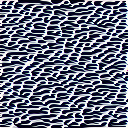

In [6]:
# Inicial (output de 3ra capa conv)
_ = render.render_vis(vgg19, "features_6:1", show_inline=True) # "capa:canal", show_inline=True printea imagen

100%|██████████| 512/512 [00:10<00:00, 48.85it/s]



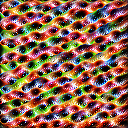

In [7]:
# Visualizacion de capa intermedia (output de 9na capa conv)
_ = render.render_vis(vgg19, "features_20:100", transforms=[transform.jitter(8)], show_inline=True) 


100%|██████████| 512/512 [00:15<00:00, 33.03it/s]



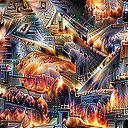

In [8]:
# Visualizacion de capa final (output de 16ta capa conv)
_ = render.render_vis(vgg19, "features_35:511", show_inline=True) 

En esta actividad estamos visualizando capas a distintas profundidades de una red entrenada para reconocimiento de imagenes de alta resolucion: VGG, la cual se caracteriza por ser bastante profunda, contando con 16 capas convolucionales.

La primera visualización desplegada corresponde a una imagen que activa fuertemente el primer canal del output de la 3ra capa convolucional, lo que nos permite representar de alguna forma el patron que pretende capturar el filtro seleccionado. Podemos ver un patron relativamente simple de líneas o segmentos semi ordenados en blanco y negro, lo que recuerda lluvia, mar, madera o arena, pero podría ser aplicable a casi cualquier cosa.

En la segunda visualización podemos apreciar ya un patron bastante más elaborado, correspondiente al canal 100 de la 9na capa convolucional. La imagen podría sugerirnos que este filtro se especializó en reconocer círculos alineados, lo que podría ser muy útil para encontrar pares de ojos, por ejemplo.

Llegando a la tercera visualización, vemos un patron que sin duda es altamente complejo. Acá ya estamos en el último canal de la última capa convolucional de la red VGG. Podemos observar un cuadro bastante abstracto, que probablemente resultó de la composición de muchas capas anteriores, en donde se podría intuir la aparición de contornos arquitectónicos, entremezclados con lo que pareciera ser llamas o fuego. Esto podría resultar de utilidad para descubrir un incendio en un edificio, por ejemplo.

###Actividad 8

In [74]:
# Define dataset class

from os import listdir
from os.path import join
from PIL import Image
import torch
from torchvision.transforms import Compose, ToTensor, Resize

class Flowers(torch.utils.data.Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.n_classes = None
        self.transform = transform
        self.imagenes = []       # Vincula el indice con un nombre de archivo
        self.imgs_to_class = []  # Vincula el indice con una clase
        self.imagenes, self.imgs_to_class = self.armar_indices(root)
    
    def armar_indices(self, root):
        n_classes = len(listdir(root)) # El número de carpetas es la cantidad de clases
        self.n_classes = n_classes
        
        contador = 0
        lista_imagenes = []
        imgs_to_class = []
        for clase in listdir(root):
            directorio = join(root, clase)
            for archivo in listdir(directorio):
                lista_imagenes.append(archivo)
                contador+=1
                imgs_to_class.append(int(clase))

        return lista_imagenes, imgs_to_class

    def obtener_imagen(self, archivo):

        im = Image.open(archivo)
        return im

    def __getitem__(self, idx):

        nombre_archivo = self.imagenes[idx]
        clase = self.imgs_to_class[idx]
        ruta_img = join(self.root, str(clase))
        ruta_img = join(ruta_img, nombre_archivo)
        img = self.obtener_imagen(ruta_img)

        if self.transform is not None:
            img = self.transform(img)
        return img, clase
    
    def __len__(self):
        return len(self.imagenes)



In [89]:
# Define Model ReTraining

from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

# Number of classes in the flower dataset
num_classes = 102

# Batch size for training
batch_size = 8

# Number of epochs to train for
num_epochs = 20

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []
    val_loss_history = []
    train_acc_hist = []
    train_loss_hist = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss.
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1) # Our prediction is the highest value between all classes

                    # backpropagation and optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            if phase == 'train':
                train_acc_hist.append(epoch_acc)
                train_loss_hist.append(epoch_loss)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s!'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best validation Accuracy: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, val_loss_history, train_acc_hist, train_loss_hist

In [90]:
def initialize_model(num_classes, use_pretrained=True):
    model_ft = models.alexnet(pretrained=use_pretrained) # we load AlexNet
    num_ftrs = model_ft.classifier[6].in_features
    model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes) # we reshape las classifier layer to adapt to new dataset
    input_size = 224

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(num_classes, use_pretrained=True)

# Print the model we just instantiated, note that last layer now has 102 classes, corresponding to flower dataset
print("Model Initialized!")
print(model_ft)

Model Initialized!
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features

In [91]:
# Load Dataset

from torchvision import datasets, models, transforms
from google.colab import drive
drive.mount('/content/drive')

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size), # resive image to alexent 224x224 required size
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

data_dir = '/content/drive/MyDrive/DL/flowers_dataset'
# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("Loading Finished")
print(image_datasets)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Initializing Datasets and Dataloaders...
Loading Finished
{'train': Dataset ImageFolder
    Number of datapoints: 5687
    Root location: /content/drive/MyDrive/DL/flowers_dataset/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           ), 'val': Dataset ImageFolder
    Number of datapoints: 2666
    Root location: /content/drive/MyDrive/DL/flowers_dataset/val
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.2

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [92]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run.
params_to_update = model_ft.parameters() # Since we are fine tuning (and not feature extracting) we will update all params
print("Params to learn:")
for name,param in model_ft.named_parameters():
  if param.requires_grad == True:
    print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 features.0.weight
	 features.0.bias
	 features.3.weight
	 features.3.bias
	 features.6.weight
	 features.6.bias
	 features.8.weight
	 features.8.bias
	 features.10.weight
	 features.10.bias
	 classifier.1.weight
	 classifier.1.bias
	 classifier.4.weight
	 classifier.4.bias
	 classifier.6.weight
	 classifier.6.bias


In [98]:
# Setup the loss funtion
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model, val_acc_hist, val_loss_hist, train_acc_hist, train_loss_hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 1/20
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6106 Acc: 0.8319
val Loss: 0.2970 Acc: 0.9216

Epoch 2/20
----------
train Loss: 0.5789 Acc: 0.8377
val Loss: 0.2644 Acc: 0.9295

Epoch 3/20
----------
train Loss: 0.5945 Acc: 0.8370
val Loss: 0.2252 Acc: 0.9385

Epoch 4/20
----------
train Loss: 0.5850 Acc: 0.8388
val Loss: 0.2995 Acc: 0.9205

Epoch 5/20
----------
train Loss: 0.5730 Acc: 0.8382
val Loss: 0.2621 Acc: 0.9321

Epoch 6/20
----------
train Loss: 0.4992 Acc: 0.8621
val Loss: 0.2297 Acc: 0.9366

Epoch 7/20
----------
train Loss: 0.5443 Acc: 0.8458
val Loss: 0.2466 Acc: 0.9347

Epoch 8/20
----------
train Loss: 0.5142 Acc: 0.8486
val Loss: 0.2617 Acc: 0.9287

Epoch 9/20
----------
train Loss: 0.5349 Acc: 0.8495
val Loss: 0.2483 Acc: 0.9325

Epoch 10/20
----------
train Loss: 0.4976 Acc: 0.8618
val Loss: 0.2306 Acc: 0.9355

Epoch 11/20
----------
train Loss: 0.4871 Acc: 0.8651
val Loss: 0.2010 Acc: 0.9441

Epoch 12/20
----------
train Loss: 0.5233 Acc: 0.8530
val Loss: 0.1739 Acc: 0.9520

Epoch 13/20
----------


In [ ]:
!pip install matplotlib==3.1.3

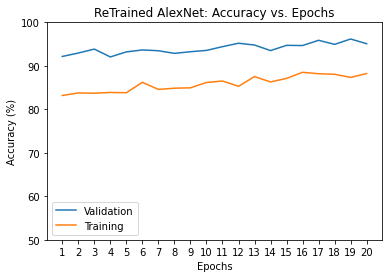

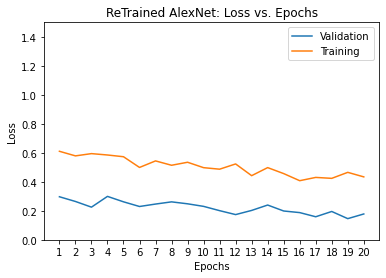

In [101]:
# Plot Results
val_acc_history = [h.cpu().numpy()*100 for h in val_acc_hist]
train_acc_history = [h.cpu().numpy()*100 for h in train_acc_hist]

plt.title("ReTrained AlexNet: Accuracy vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.plot(range(1,num_epochs+1), val_acc_history, label="Validation")
plt.plot(range(1,num_epochs+1), train_acc_history, label="Training")
plt.ylim((50,100))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

val_loss_history = [h for h in val_loss_hist]
train_loss_history = [h for h in train_loss_hist]

plt.title("ReTrained AlexNet: Loss vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(range(1,num_epochs+1), val_loss_history, label="Validation")
plt.plot(range(1,num_epochs+1), train_loss_history, label="Training")
plt.ylim((0.0,1.5))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

Analizando ambos gráficos podemos notar que el modelo muestra mejores rendimientos a lo largo del re-entrenamiento, si bien sin duda va aumentando su precisión, no aumenta más que algunos puntos porcentuales. Esto lo podemos explicar por el pre entrenamiento con el que viene la red (AlexNet en este caso): como ya fue entrenada para clasificar imágenes, para su nuevo dataset su rendimiento comienza en valores muy altos (90%+).

### Actividad 9

100%|██████████| 512/512 [00:03<00:00, 160.66it/s]



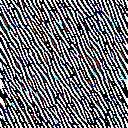

100%|██████████| 512/512 [00:02<00:00, 233.99it/s]



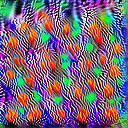

100%|██████████| 512/512 [00:02<00:00, 210.70it/s]



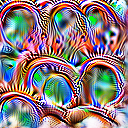

In [122]:
from lucent.optvis import render, param, transform, objectives

# Visualizacion de capa inicial (output de 1ra capa conv) (64)
_ = render.render_vis(model, "features_1:18", show_inline=True) 
# Visualizacion de capa intermedia (output de 3ra capa conv) (384)
_ = render.render_vis(model, "features_7:201", transforms=[transform.jitter(8)], show_inline=True) 
# Visualizacion de capa final (output de 5ta capa conv) (256)
_ = render.render_vis(model, "features_11:12", transforms=[transform.jitter(8)], show_inline=True) 

Partiendo por las visualizaciones de las features de las capas, podemos observar nuevamente un paulatino incremento en la complejidad de los patrones captados por cada capa de la red. Alexnet es considerablemente menos profunda que VGG (analizada anteriormente) por lo que ya en la 5ta capas presenta patrones sumamente abstractos como podemos ver. Cabe mencionar que como esta red fue re entrenada (fine tuned) sus filtros no solo estan configurados para reconocer patrones de flores, sino tambien de otras clases de imagenes de ImageNet.


100%|██████████| 512/512 [00:06<00:00, 84.98it/s]



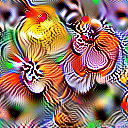

100%|██████████| 512/512 [00:06<00:00, 85.26it/s]



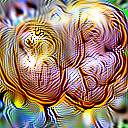

100%|██████████| 512/512 [00:06<00:00, 84.58it/s]



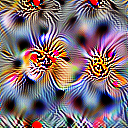

In [135]:
_ = render.render_vis(model, "labels:42", show_inline=True) # "Ave del Paraiso"

_ = render.render_vis(model, "labels:9", show_inline=True) # "Echinops"

_ = render.render_vis(model, "labels:53", show_inline=True) # "Girasol"

Siguiendo con las visualizaciones de los labels, vemos interesantes patrones: la primera imagen corresponde a Gladiolas, flores que crecen en grupos y muestran variados colores (lo cual se representa en el dataset), por lo que podemos ver una explosión de colores y algunos puntos negros para reconocer los grupos. La segunda corresponde a Echinops, flor esférica con muchas puntas, lo cual se puede apreciar en el patron circular y segmentado de la segunda imagen. Finalmente tenemos la imagen que representa a la clase de Girasoles, la red probablemente aprendió a dectectarlos por su prominente centro oscuro, más que su característico color amarillo, ya que es más distintivo respecto a las otras clases.

#Referencias

1. *K. He, X. Zhang, S. Ren, and J. Sun. Deep residual learning for image recognition. In CVPR.*
2. *Lucent Repo Tutorial* https://github.com/greentfrapp/lucent
3. *Pytorch v1.2. Tutorials: Finetuning Torchvision Models* https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html